In [68]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
import numpy as np
import io
import tensorflow as tf
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image, ImageOps


from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D ,BatchNormalization, Flatten, Dropout

import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:

# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:

# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [6]:
!kaggle datasets download mehradaria/covid19-lung-ct-scans -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 99% 1.02G/1.02G [00:14<00:00, 59.8MB/s]
100% 1.02G/1.02G [00:14<00:00, 75.2MB/s]


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_data_dir = "/content/COVID-19_Lung_CT_Scans"
output_base_dir = "/content/Splitted_dataset"

# Paths for train, validation, and test splits
train_dir = os.path.join(output_base_dir, "train")
valid_dir = os.path.join(output_base_dir, "validation")
test_dir = os.path.join(output_base_dir, "test")

# Create directories for train, validation, and test splits
for split_dir in [train_dir, valid_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Get list of class subdirectories
classes = [d for d in os.listdir(original_data_dir) if os.path.isdir(os.path.join(original_data_dir, d))]

for class_name in classes:
    # Paths for the current class
    class_dir = os.path.join(original_data_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    # Create class subdirectories
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # List all images in the class directory
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split into train, validation, and test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.125, random_state=42)  # 10% of train+valid

    # Move files to respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in valid_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(valid_class_dir, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("Dataset split complete!")


Dataset split complete!


In [24]:
batch_size = 128
IMAGE_SIZE = 128
image_shape = (128,128,1)

In [57]:
# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    '/content/Splitted_dataset/train/',
    target_size=(128, 128),  # Ensure target size matches model input
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training' ,
        color_mode='grayscale'  # Ensure grayscale images are loaded
# Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    '/content/Splitted_dataset/validation/',
    target_size=(128, 128),  # Ensure target size matches model input
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation' ,
        color_mode='grayscale'  # Ensure grayscale images are loaded
# Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    '//content/Splitted_dataset/test/',
    target_size=(128, 128),  # Ensure target size matches model input
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
            color_mode='grayscale'  # Ensure grayscale images are loaded

)

Training Images:
Found 5169 images belonging to 2 classes.
Validating Images:
Found 104 images belonging to 2 classes.
Test Images:
Found 1688 images belonging to 2 classes.


In [42]:

# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['COVID-19', 'Non-COVID-19']
Validation Class Names: ['COVID-19', 'Non-COVID-19']
Test Class Names: ['COVID-19', 'Non-COVID-19']
Number of Training Classes: 2
Number of Validation Classes: 2
Number of Test Classes: 2


In [43]:
class_names = train_class_names


In [49]:
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=input_shape))
model.add(Conv2D(16,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
#model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
#model.add(Dense(4, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

In [50]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 61, 61, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,050 (1.19 MB)

 Trainable params: 312,050 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 61, 61, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,050 (1.19 MB)

 Trainable params: 312,050 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# 13. Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7
)

# 14. Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)


In [53]:
history = model.fit(
    train_data,  # Replace with your training dataset
    validation_data=valid_data,  # Replace with your validation dataset
    epochs=25,
    batch_size=batch_size,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 569ms/step - accuracy: 0.8879 - loss: 0.3981 - val_accuracy: 0.8942 - val_loss: 0.3591 - learning_rate: 0.0010
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 471ms/step - accuracy: 0.8958 - loss: 0.3284 - val_accuracy: 0.8942 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 480ms/step - accuracy: 0.8869 - loss: 0.3447 - val_accuracy: 0.8942 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 563ms/step - accuracy: 0.8841 - loss: 0.3473 - val_accuracy: 0.8942 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.8852 - loss: 0.3094 - val_accuracy: 0.8942 - val_loss: 0.3349 - learning_rate: 0.0010
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 473ms/step - accuracy: 0.8993 - loss: 0.2621 - val_accuracy: 0.9038 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 471ms/step - accuracy: 0.9311 - loss: 0.2067 - val_

In [55]:
model.save('covid_or_not.keras')

# Training and Evaluation


In [58]:
Y_pred = model.predict(test_data)
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.7521 - loss: 0.5171
Test loss: 0.5548719763755798
Test accuracy: 0.7529621124267578


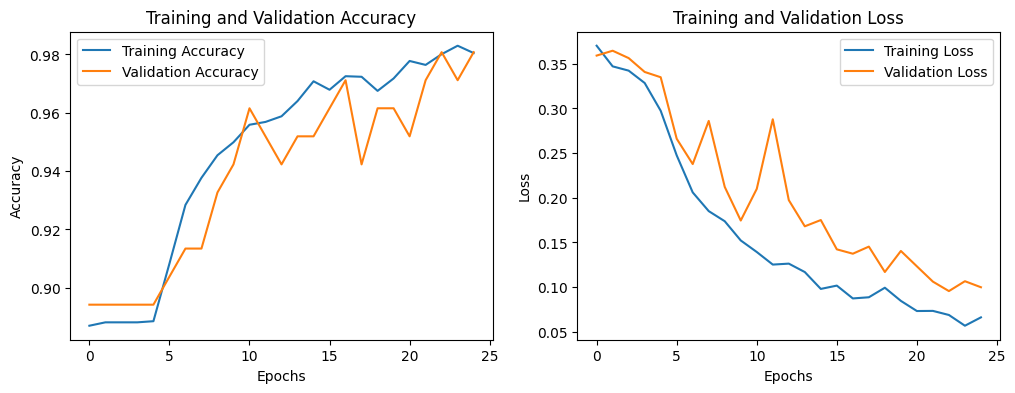

In [59]:


# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
Classification Report:
               precision    recall  f1-score   support

    COVID-19       0.98      0.99      0.98        93
Non-COVID-19       0.90      0.82      0.86        11

    accuracy                           0.97       104
   macro avg       0.94      0.90      0.92       104
weighted avg       0.97      0.97      0.97       104

Precision: 0.97, Recall: 0.97, F1 Score: 0.97


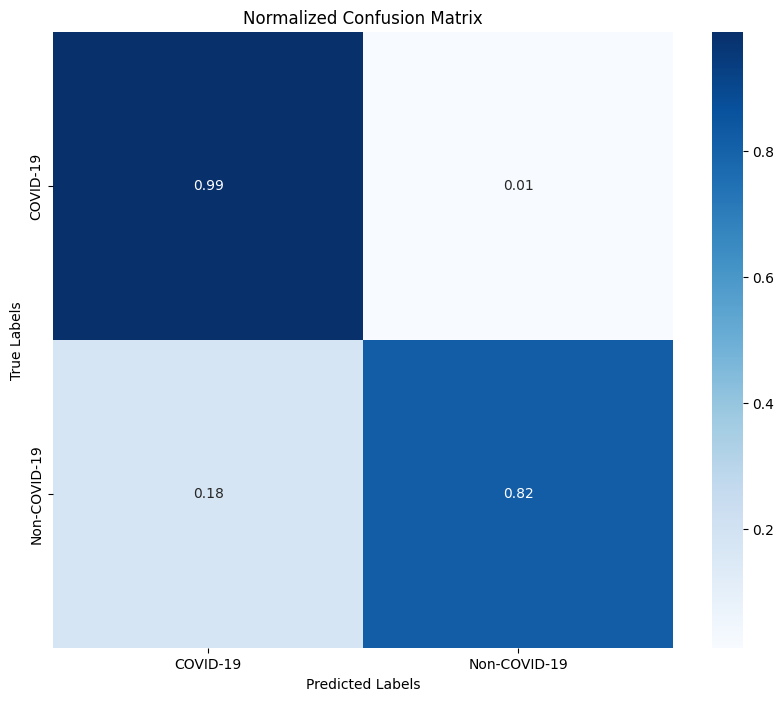

In [62]:
# Predict on validation data
Y_pred = model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Image 1: Predicted correctly: COVID-19
Image 2: Predicted correctly: COVID-19
Image 3: Predicted incorrectly. True: COVID-19, Pred: Non-COVID-19
Image 4: Predicted correctly: COVID-19
Image 5: Predicted incorrectly. True: COVID-19, Pred: Non-COVID-19


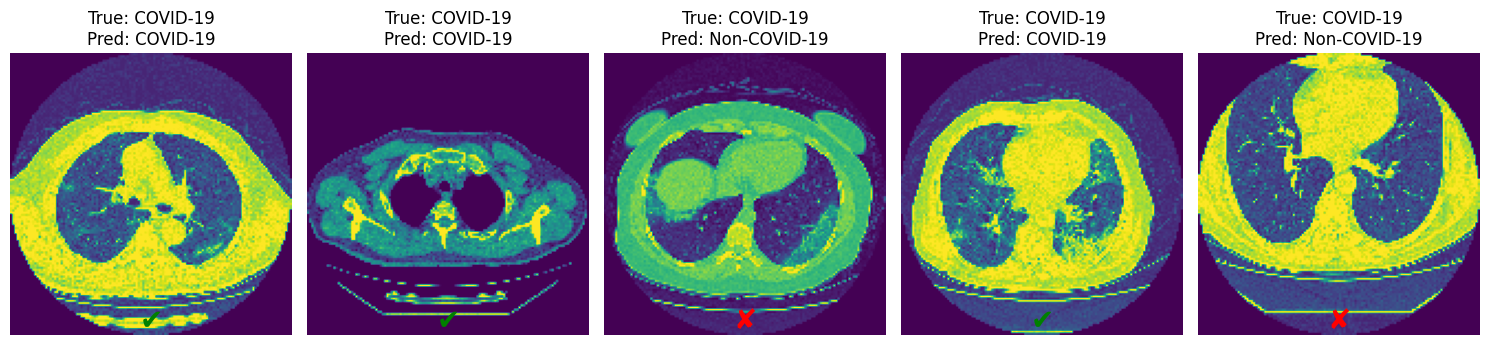

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming `test_data` is the test data generator with images and labels
# Assuming `model` is the trained model

# Fetch the first 5 images and their true labels from the test data
test_images, test_labels = next(test_data)  # Get the first batch of images and labels

# Convert the one-hot encoded labels to class indices
test_labels_classes = np.argmax(test_labels, axis=1)

# Predict on these images
Y_pred = model.predict(test_images)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Get the class names (assuming you have these from the validation data or training)
class_names = list(test_data.class_indices.keys())

# Set up a subplot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Plot the first 5 images along with the predicted and true labels
for i in range(5):
    axes[i].imshow(test_images[i])  # Display image
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'True: {class_names[test_labels_classes[i]]}\nPred: {class_names[Y_pred_classes[i]]}')

    # Check if the predicted label matches the true label
    if test_labels_classes[i] == Y_pred_classes[i]:
        # Display a green tick (✔) for correct prediction
        axes[i].text(0.5, 0.05, '✔', fontsize=20, color='green', ha='center', va='center', transform=axes[i].transAxes)
        print(f'Image {i+1}: Predicted correctly: {class_names[test_labels_classes[i]]}')
    else:
        # Display a red cross (✘) for incorrect prediction
        axes[i].text(0.5, 0.05, '✘', fontsize=20, color='red', ha='center', va='center', transform=axes[i].transAxes)
        print(f'Image {i+1}: Predicted incorrectly. True: {class_names[test_labels_classes[i]]}, Pred: {class_names[Y_pred_classes[i]]}')

plt.tight_layout()
plt.show()

# # Optionally, print the classification report for the entire test set
# print("Classification Report:\n", classification_report(test_labels_classes, Y_pred_classes, target_names=class_names))


# GUI Implementation


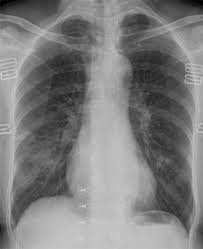

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


In [69]:
model = model

# Define class names
class_names = class_names

# Function to preprocess and predict the image
def predict_image(img):
    # Resize image to match model input size
    img_resized = img.resize((128, 128))

    # Convert to grayscale
    img_gray = ImageOps.grayscale(img_resized)  # Convert image to grayscale

    # Normalize and convert to numpy array
    img_array = np.array(img_gray) / 255.0  # Normalize grayscale image

    # Add channel dimension (grayscale images have 1 channel)
    img_array = np.expand_dims(img_array, axis=-1)  # Add the channel dimension (1 channel)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1 image)

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = class_names[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))
